# Shazam do GTZAN

**Objetivos**
1. Entender o Shazam!

**Resultado Esperado**
1. Saber criar um índice de constelações
1. Realizar consultas no mesmo

**Caso queira indexar tudo, recomendo o uso da biblioteca sparse, descomente abaixo**

In [ ]:
# !pip install sparse
# import sparse

In [ ]:
from numba import jit

import librosa
import librosa.display

import IPython.display as ipd

import matplotlib.pyplot as plt

import numpy as np
import os
import pandas as pd

plt.rcParams['axes.labelsize']  = 16
plt.rcParams['axes.titlesize']  = 16
plt.rcParams['legend.fontsize'] = 16
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['lines.linewidth'] = 2

plt.ion()

## Introdução

Neste notebook vamos tentar montar um [Shazam](https://shazam.com). Criado em meados de 2003 \[[1](https://www.ee.columbia.edu/~dpwe/papers/Wang03-shazam.pdf)\], o Shazam é um serviço que identifica músicas com base em clipes pequenos. No começo dos anos 2010s, o advento de aplicativos de celulares popularizou o serviço Shazam. Com o passar dos anos, as ideias do Shazam foram copiadas por empresas como a Google a Apple, que incluem variações do serviço de descoberta nos seus sistemas operacionais Android e IOs. Se não me engano, a Apple usa APIs do Shazam, enquanto a Google tem sua versões própria.

![](https://digitalagencynetwork.com/wp-content/uploads/2017/12/confirmed-apple-bought-shazam-app-reasonable-point.jpg)

O funcionamento do Shazam é feito através da técnica de *audio fingerprinting*. Aqui, um índice invertido de atributos musicais é criado. Com tal índice, podemos rapidamente identificar uma música através de um clipe pequeno da mesma. A figura abaixo mostra a ideia de como um serviço seria implementado no mundo real. Aqui, vamos fazer uma versão simples em memória.

![Audio Finger](https://www.audiolabs-erlangen.de/resources/MIR/FMP/data/C7/FMP_C7_F02.png)

## Base de Dados

Para nossa tarefa, vamos fazer uso da base GTZAN. A base GTZAN é composta por 1.000 trechos de música e áudio de meio minuto, classificados individualmente em dez categorias. Por hora, vamos ignorar as categorias e focar apenas nas músicas. Para um melhor entendimento do GTZAN leia a referência \[[2](https://arxiv.org/pdf/1306.1461.pdf)\]. 

### A base de dados que será indexada (GTZAN)

Toda a base GTZAN pode ser encontrada no [Kaggle](https://www.kaggle.com/andradaolteanu/gtzan-dataset-music-genre-classification). Caso necessite, uma versão também pode ser encontrada no drive junto deste notebook.

Abaixo mostramos as pastas e arquivos do GTZAN. Tais músicas vem no formato wav. Sua tarefa será montar um índice de um **subconjunto** de tais músicas. Já explico.

In [ ]:
!ls Data/genres_original

In [ ]:
!ls Data/genres_original/blues | head

### A base de dados de consulta (MIREX-2020)

Como sua tarefa é montar um Shazam, precisamos de uma base de consultas. Desde 2005, a [Music Information Retrieval Evaluation eXchange (MIREX 2020)](https://www.music-ir.org/mirex) organia competições no tema de recuperação de informação musical. Já fazem alguns anos, desde 2013, onde anualmente uma das competições do MIREX é no tema de *audio fingerprinting* (nossa tarefa). O link ao lado contém a descrição da tarefa [Audio Fingerprinting MIREX 2020](https://www.music-ir.org/mirex/wiki/2020:Audio_Fingerprinting).

Para simular o uso do Shazam, junto com tal competição, uma base de dados de consultas é fornecida. Tal base foi gravada em telefones celulares em diferentes ambientes. Para entender o formato de tal base, segue uma lista dos arquivos.

In [ ]:
!ls -l mir-2013-GeorgeDataset_snippet\(10sec\)_1062

Observe como cada arquivo corresponde a uma música do GTZAN. Além do mais, três clipes de 10 segundos são fornecidos por música. Por exemplos, a música `blues.00000.wav`do GTZAN tem como respostas os clipes: `blues.00000-snippet-10-0.wav`, `blues.00000-snippet-10-10.wav`, `blues.00000-snippet-10-20.wav`.

## Sua Tarefa

Sabendo das bases acima, sua tarefa será em indexar e mensurar a Precision@1 (fração de acertos na primeira posição retornada) das músicas acima. **Por questões de memória limitada, você pode indexar apenas as músicas de consulta, não precisa indexar todo GTZAN. Faça tudo na memória principal mesmo**.

Para realizar sua tarefa crie mapas de constetalação das músicas e da consulta.

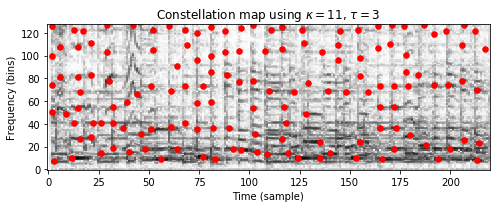

### *Importante*: Fourier no GTZAN

No GTZAN, cada música é gravada a uma taxa de amostragem de 22,05 kHz e arquivos de áudio mono de 16 bits no formato `.wav`. *Como toda música tem a mesma taxa de amostragem, os índices discretos da transformada de Fourier são os mesmos para todas as músicas. ELAS JÁ VEM BINARIZADAS NO EIXO-Y do mapa de constelação*.

## Carregando os Espectrogramas

O código abaixo carrega os espectrogramas. Coloquei também um função que plota os mesmos.

In [ ]:
import warnings
warnings.filterwarnings('ignore')

def plot_spec(stft, sr, constelation=None):
    fig, ax = plt.subplots(figsize=(1.618 * 16, 16))
    img = librosa.display.specshow(librosa.amplitude_to_db(stft, ref=np.max),
                                   y_axis='log',
                                   x_axis='time',
                                   hop_length=sr,
                                   ax=ax)
    fig.colorbar(img, ax=ax, format="%+2.0f dB")
    if constelation is not None and constelation.any():
        x, y = np.where(constelation)
        ax.scatter(x, y, s=100, alpha=0.8, color='red')
    fig.show()

**Observe como passo o `hop_length=sr` no stft**. Como estou com uma música com taxa SR por segundo, tiro a média a cada SR frames. Isso deixa meu espectrograma em SEGUNDOS. Algumas musicas passam um pouco de 30 segundos, portanto pego os trinta na marra.

In [ ]:
def my_stft(wave, sr):
    stft_complex = librosa.stft(wave, hop_length=sr) # deve ter approx 30 secs
    stft = np.abs(stft_complex) # tira a norma do real e imag
    return stft[:, :30] # força 30 secs

In [ ]:
wave, sr = librosa.load('Data/genres_original/blues/blues.00001.wav',
                        mono=True)
stft = my_stft(wave, sr)
plot_spec(stft, sr)
stft.shape

### Mapa de Constelação

O mapa pode ser implementado com a chamada: https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.maximum_filter.html. O `mode='constant'` faz um preenchimento nas bordas para garantir que tudo funcione. O `size` diz o tamanho do filtro que vamos usar.

In [ ]:
from scipy import ndimage

def constellation_map(stft, kappa=7, tau=7, thresh=0.01):
    result = ndimage.maximum_filter(stft, size=[2*kappa+1, 2*tau+1], mode='constant')
    C = np.logical_and(stft == result, result > thresh)
    return C

In [ ]:
constelation = constellation_map(stft, kappa=2, tau=2)
plot_spec(stft, sr, constelation)

## Índice

Observe como cada consulta precisa ser comparada com todas as seções (tendo a mesma duração da consulta) de todas as músicas contidas no base de dados. Tal estratégia de busca exaustiva, cujo tempo de execução depende linearmente do número e do tamanho da base de dados, não é viável. Portanto você deve implementar um índice como visto em sala de aula. A função `match_query_gtzan` lhe ajuda a carregar apenas os arquivos que existem na base de consultas.

In [ ]:
import glob
import os

def match_query_gtzan():
    rv = {}
    path = os.path.join('mir-2013-GeorgeDataset_snippet(10sec)_1062', '*.wav')
    for wav_fpath in glob.glob(path):
        file_name = os.path.basename(wav_fpath)
        file_name_gztan = '{}{}'.format(file_name.split('-')[0], '.wav')
        genre = file_name_gztan.split('.')[0]
        rv[wav_fpath] = os.path.join('Data', 'genres_original', genre, file_name_gztan)
    return rv
matches = match_query_gtzan()
print(list(matches.items())[:10])

In [ ]:
from collections import defaultdict

def index(colecao_de_stfts, kappa, tau):
    pass
        
index(matches.values(), kappa=5, tau=5)

## Problemas

1. Implemente o índice acima. É possível implementar o mesmo na memória. Use estruturas python ou uma matriz esparsa 3d (um tensor). Veja a descrição do lab. Da para fazer sem o sparse, mas não deve funcionar na base toda.
1. Realize as consultas e mensure o seu valor de precision@1
1. Qual o efeito do kappa e do tau no seu resultado?
1. Mude seu código para funciona na base toda (*extra*)